In [3]:
import tensorflow as tf
import numpy as np
import os
import shutil
from keras.preprocessing.image import ImageDataGenerator

In [1]:
base_path = "./dataset/plant_disease_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"

In [29]:
train_dir = os.path.join(base_path,"train")
valid_dir = os.path.join(base_path,"valid")
label_map = {}

for item in os.listdir(train_dir):
    splitted = item.split("___")
    if splitted[0] in label_map:
        label_map[splitted[0]] = label_map[splitted[0]] + 1
    else:
        label_map[splitted[0]] = 1
# print(label_map)
labels = []
for item in label_map:
    if label_map[item] > 1:
        labels.append(item)
labels

['Apple',
 'Cherry_(including_sour)',
 'Corn_(maize)',
 'Grape',
 'Peach',
 'Pepper,_bell',
 'Potato',
 'Strawberry',
 'Tomato']

In [7]:
import csv

In [10]:
train_dir = os.path.join(base_path,"train(data_reduction)")

data_map={}

for item in os.listdir(train_dir):
    splitted = item.split("___")
    if splitted[0] not in data_map:
        data_map[splitted[0]]=[splitted[1]]
    else:
        data_map[splitted[0]].append(splitted[1])
# csv.DictWriter()


for item in data_map:
    print(data_map[item])



['Apple_scab', 'Black_rot', 'Cedar_apple_rust', 'healthy']
['healthy', 'Powdery_mildew']
['Cercospora_leaf_spot Gray_leaf_spot', 'Common_rust_', 'healthy', 'Northern_Leaf_Blight']
['Black_rot', 'Esca_(Black_Measles)', 'healthy', 'Leaf_blight_(Isariopsis_Leaf_Spot)']
['Bacterial_spot', 'healthy']
['Bacterial_spot', 'healthy']
['Early_blight', 'healthy', 'Late_blight']
['healthy', 'Leaf_scorch']
['Bacterial_spot', 'Early_blight', 'healthy', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_mosaic_virus', 'Tomato_Yellow_Leaf_Curl_Virus']


In [36]:
# data reduction
os.mkdir(os.path.join(base_path,"train(data_reduction)"))
for item in os.listdir(train_dir):
    splitted = item.split("___")
    if splitted[0] in labels:
        shutil.copytree(os.path.join(train_dir,item),os.path.join(os.path.join(base_path,"train(data_reduction)"),item))

In [37]:
# data reduction
os.mkdir(os.path.join(base_path,"valid(data_reduction)"))
for item in os.listdir(valid_dir):
    splitted = item.split("___")
    if splitted[0] in labels:
        shutil.copytree(os.path.join(valid_dir,item),os.path.join(os.path.join(base_path,"valid(data_reduction)"),item))

In [3]:
train_dir = os.path.join(base_path,"train(data_reduction)")
valid_dir = os.path.join(base_path,"valid(data_reduction)")

training_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      horizontal_flip=True,
                                      zoom_range=0.2)

train_generator = training_datagen.flow_from_directory(directory=train_dir,
                                                       target_size=(224, 224),
                                                       class_mode='categorical',
                                                       batch_size=32)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(directory=valid_dir,
                                                              target_size=(224, 224),
                                                              class_mode='categorical',
                                                              batch_size=32)

label_classes = list(train_generator.class_indices.keys())
label_classes

Found 60930 images belonging to 33 classes.
Found 15231 images belonging to 33 classes.


['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [4]:
from keras.applications.resnet_v2 import ResNet50V2

In [5]:
pre_trained_resnet = ResNet50V2(input_shape=(224,224,3),
                                include_top=False,
                                weights='imagenet')

pre_trained_resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [6]:
# for layer in pre_trained_resnet.layers[:-5]:
#     layer.trainable = False

class stoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.9):
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True


In [7]:
model = tf.keras.models.Sequential([
    pre_trained_resnet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(label_classes), activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=100,
                    callbacks=stoppingCallback(),
                    verbose=1)

Epoch 1/100
   2/1905 [..............................] - ETA: 1:07:50 - loss: 11.8891 - accuracy: 0.0469

: 

In [37]:
from keras.utils import load_img
from keras.utils import get_file

img = "https://ik.imagekit.io/kuromaru/elephant_b0cLsAcre.webp?updatedAt=1703181648131"
imgurl = get_file(origin=img)
image = load_img(imgurl, target_size=(224,224))




In [13]:
from matplotlib import pyplot as plt

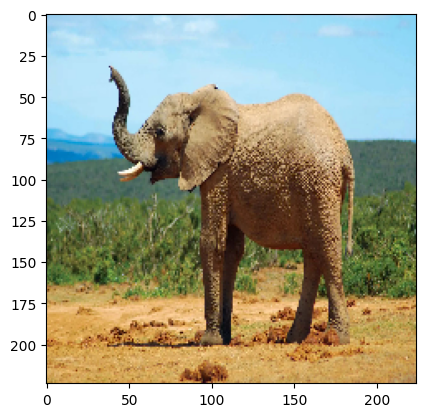

In [38]:
plt.imshow(image)

In [39]:
from keras.models import load_model
from tensorflow.keras.preprocessing import image as imgg
mdl = load_model('model.h5')
x = imgg.img_to_array(image)
x = np.array([x])
prediction = mdl.predict(x)
class_labels = ['CANE', 'CAVALLO', 'ELEFANTE', 'FARFALLA', 'GALLINA', 'GATTO', 'MUCCA',
               'PECORA', 'RAGNO', 'SCOIATTOLO']
class_labels[np.argmax(prediction)]

1/1 [==============================] - 0s 383ms/step


'ELEFANTE'